This code was implemented to work on the FG (Functional Groups) dataset. the dataset has 3315 data points. It mounted Google Drive to access the SQLite database containing molecular systems from the FG dataset and extracted the structural information for each system. The atomic positions and atomic numbers were parsed from binary blobs, and each molecule was converted into a graph where atoms served as nodes and edges were formed between atoms closer than 3.0 Å. These graphs were stored as `Data` objects using PyTorch Geometric, creating a graph-based representation of the FG dataset suitable for downstream machine learning tasks such as property prediction or classification.

In [16]:
!pip install torch torchvision torchaudio torch-geometric ase

from google.colab import drive
drive.mount('/content/drive')

db_path = "/content/drive/MyDrive/project ch5650/fg_dataset (1).db"
import sqlite3
import numpy as np
import torch
from torch_geometric.data import Data
import struct

def parse_positions(blob, natoms):
    return np.frombuffer(blob, dtype=np.float64).reshape((natoms, 3))

def parse_numbers(blob, natoms):
    return np.frombuffer(blob, dtype=np.int32)[:natoms]

def extract_graphs_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT id, positions, numbers, natoms FROM systems")
    rows = cursor.fetchall()

    data_list = []
    for row in rows:
        sys_id, pos_blob, num_blob, natoms = row
        try:
            positions = parse_positions(pos_blob, natoms)
            atom_types = parse_numbers(num_blob, natoms)

            pos_tensor = torch.tensor(positions, dtype=torch.float)
            x = torch.tensor(atom_types, dtype=torch.long).view(-1, 1)

            # Build edges based on distance < 3.0 Å
            edge_index = []
            for i in range(natoms):
                for j in range(natoms):
                    if i != j:
                        dist = np.linalg.norm(positions[i] - positions[j])
                        if dist < 3.0:
                            edge_index.append([i, j])

            if len(edge_index) == 0:
                continue  # skip graphs with no edges

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            data = Data(x=x, edge_index=edge_index, pos=pos_tensor)
            data_list.append(data)
        except Exception as e:
            print(f"Error in system {sys_id}: {e}")

    conn.close()
    return data_list

# 5. Extract graphs
graphs = extract_graphs_from_db(db_path)
print(f" Loaded {len(graphs)} graphs.")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

This code snippet was used to inspect metadata stored in the `key_value_pairs` column of the `systems` table in the FG dataset database. Here's what each part did:

1. Connected to the SQLite database at the specified path (`db_path`).
2. Executed a SQL query to retrieve the `key_value_pairs` column from the first 5 entries in the `systems` table, and loaded the results into a Pandas DataFrame.
3. Closed the database connection.
4. Iterated over each row in the DataFrame and parsed the JSON-formatted string in the `key_value_pairs` column using Python's `json.loads()` function.
5. Printed the parsed JSON data, which likely included system-specific metadata such as energy values, calculation settings, or chemical identifiers.

This was useful for understanding the additional information available for each molecular system in the FG dataset.


In [17]:
import json
conn = sqlite3.connect(db_path)
df = pd.read_sql("SELECT key_value_pairs FROM systems LIMIT 5", conn)
conn.close()

for i, row in df.iterrows():
    print(json.loads(row['key_value_pairs']))


{'calc_type': 'gas', 'metal': 'N/A', 'facet': 'N/A', 'family': 'amides', 'e_tot': -35.32056159, 'e_gas_dft': -35.32056159, 'e_gas_add': -35.05214705, 'e_slab': 'N/A', 'e_ads_dft': 'N/A', 'e_ads_add': 'N/A', 'scaled_e_ads': -35.32056159, 'n_C': 1, 'n_H': 3, 'n_O': 1, 'n_N': 1, 'n_S': 0}
{'calc_type': 'gas', 'metal': 'N/A', 'facet': 'N/A', 'family': 'amides', 'e_tot': -51.71780145, 'e_gas_dft': -51.71780145, 'e_gas_add': -49.87594196, 'e_slab': 'N/A', 'e_ads_dft': 'N/A', 'e_ads_add': 'N/A', 'scaled_e_ads': -51.71780145, 'n_C': 2, 'n_H': 5, 'n_O': 1, 'n_N': 1, 'n_S': 0}
{'calc_type': 'gas', 'metal': 'N/A', 'facet': 'N/A', 'family': 'amides', 'e_tot': -52.15327434, 'e_gas_dft': -52.15327434, 'e_gas_add': -49.87594196, 'e_slab': 'N/A', 'e_ads_dft': 'N/A', 'e_ads_add': 'N/A', 'scaled_e_ads': -52.15327434, 'n_C': 2, 'n_H': 5, 'n_O': 1, 'n_N': 1, 'n_S': 0}
{'calc_type': 'gas', 'metal': 'N/A', 'facet': 'N/A', 'family': 'amides', 'e_tot': -68.36988191, 'e_gas_dft': -68.36988191, 'e_gas_add': -64

This code extended the previous graph extraction process to include adsorption energy values from the FG dataset, making the data suitable for supervised machine learning tasks like regression.


1. Connected to the SQLite database and retrieved molecular systems along with their associated metadata (`key_value_pairs`).
2. For each system:

   * Parsed the metadata JSON and checked if the `scaled_e_ads` (adsorption energy) was available and valid.
   * Skipped systems without a valid adsorption energy.
   * If valid, it extracted the `scaled_e_ads` value and stored it as the graph label `y`.
3. Parsed atomic positions and types, and built graph structures:

   * Atoms were converted into node features.
   * Edges were created between atoms within 3.0 Å of each other.
4. Each system with valid edges and adsorption energy was turned into a `Data` object containing `x`, `edge_index`, `pos`, and `y`.
5. Returned a list of these graph objects, each labeled with an adsorption energy.

This made it possible to use the graphs for training models to predict adsorption energy, a key task in catalysis and materials science.


In [18]:
def extract_graphs_with_adsorption_energy(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT id, positions, numbers, natoms, key_value_pairs FROM systems")
    rows = cursor.fetchall()

    data_list = []
    for row in rows:
        sys_id, pos_blob, num_blob, natoms, kv_json = row
        try:
            kv = json.loads(kv_json)
            if kv.get('scaled_e_ads') in [None, "N/A"]:
                continue  # skip if no adsorption energy

            y = float(kv['scaled_e_ads'])

            positions = parse_positions(pos_blob, natoms)
            atom_types = parse_numbers(num_blob, natoms)

            pos_tensor = torch.tensor(positions, dtype=torch.float)
            x = torch.tensor(atom_types, dtype=torch.long).view(-1, 1)

            edge_index = []
            for i in range(natoms):
                for j in range(natoms):
                    if i != j:
                        dist = np.linalg.norm(positions[i] - positions[j])
                        if dist < 3.0:
                            edge_index.append([i, j])

            if len(edge_index) == 0:
                continue

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            data = Data(x=x, edge_index=edge_index, pos=pos_tensor, y=torch.tensor([y], dtype=torch.float))
            data_list.append(data)
        except Exception as e:
            print(f"Error in system {sys_id}: {e}")

    conn.close()
    return data_list

# Reload graphs with adsorption energy targets
graphs = extract_graphs_with_adsorption_energy(db_path)
print(f" Loaded {len(graphs)} graphs with adsorption energies.")


✅ Loaded 9396 graphs with adsorption energies.


In [19]:
# Training
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch import nn

class SimpleGNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = nn.Linear(64, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x.float(), edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# Train loop
loader = DataLoader(graphs, batch_size=32)
model = SimpleGNN(in_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


<ipython-input-19-d012d2b6a827>:31: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-19-d012d2b6a827>:31: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 0, Loss: 463016.7107
Epoch 1, Loss: 265591.0983
Epoch 2, Loss: 239045.7583
Epoch 3, Loss: 275377.2978
Epoch 4, Loss: 237372.6503
Epoch 5, Loss: 249777.4208
Epoch 6, Loss: 239008.9033
Epoch 7, Loss: 214990.7521
Epoch 8, Loss: 276648.3689
Epoch 9, Loss: 245204.0104


In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train loop with additional metrics
loader = DataLoader(graphs, batch_size=32)
model = SimpleGNN(in_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []

    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)

        # Collect predictions and true values for metric calculation
        all_preds.append(out.detach().cpu().numpy())
        all_targets.append(batch.y.detach().cpu().numpy())

        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Flatten the lists of predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Calculate additional metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 0, Loss: 493567.7880, MSE: 1744.1798, RMSE: 41.7634, R2: -1.0122, MAE: 31.7016


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 1, Loss: 280421.4576, MSE: 956.0859, RMSE: 30.9206, R2: -0.1030, MAE: 22.0878


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 2, Loss: 265340.5411, MSE: 867.7761, RMSE: 29.4580, R2: -0.0011, MAE: 20.9969


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 3, Loss: 234509.3838, MSE: 770.4363, RMSE: 27.7567, R2: 0.1112, MAE: 19.9799


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 4, Loss: 236669.5917, MSE: 761.2992, RMSE: 27.5917, R2: 0.1217, MAE: 19.7982


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 5, Loss: 242289.5757, MSE: 783.5894, RMSE: 27.9927, R2: 0.0960, MAE: 20.5310


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 6, Loss: 204419.6004, MSE: 659.2812, RMSE: 25.6765, R2: 0.2394, MAE: 18.4299


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 7, Loss: 219126.1136, MSE: 710.7071, RMSE: 26.6591, R2: 0.1801, MAE: 19.2135


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


Epoch 8, Loss: 264841.6305, MSE: 824.7529, RMSE: 28.7185, R2: 0.0485, MAE: 21.7993
Epoch 9, Loss: 242868.3391, MSE: 770.1166, RMSE: 27.7510, R2: 0.1115, MAE: 21.2059


<ipython-input-20-905197b3c4f4>:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)


This code trained a Graph Convolutional Network (GCN) to predict adsorption energies from molecular graph data derived from the FG dataset. It began by normalizing the node features and target adsorption energy values to stabilize training. The `ImprovedGNN` model was defined with three GCN layers followed by global mean pooling and a linear output layer. A `DataLoader` was used to batch and shuffle the graph data, and the model was trained over 100 epochs using the Adam optimizer and mean squared error loss. During each epoch, predictions and targets were collected, denormalized, and evaluated using common regression metrics: MSE, RMSE, R², and MAE. This setup allowed for efficient training and real-time monitoring of model performance on predicting adsorption energies.

In [44]:
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F
from torch import nn
import torch
import numpy as np

# =======================
# Normalize node features and targets
# =======================
all_targets = torch.cat([g.y for g in graphs])
mean_y = all_targets.mean()
std_y = all_targets.std()

for g in graphs:
    g.x = (g.x.float() - g.x.float().mean()) / g.x.float().std()  # Normalize node features as float
    g.y = (g.y - mean_y) / std_y                                   # Normalize target

# =======================
# GCN Model Definition
# =======================
class ImprovedGNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 64)
        self.lin = nn.Linear(64, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# =======================
# Training Setup
# =======================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loader = DataLoader(graphs, batch_size=32, shuffle=True)
model = ImprovedGNN(in_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# =======================
# Training Loop
# =======================
for epoch in range(100):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets_epoch = []

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)

        # Fix target shape
        loss = F.mse_loss(out, batch.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Collect predictions and targets
        all_preds.append(out.detach().cpu().numpy())
        all_targets_epoch.append(batch.y.view(-1, 1).cpu().numpy())

    # Combine and denormalize
    all_preds = np.concatenate(all_preds)
    all_targets_epoch = np.concatenate(all_targets_epoch)
    all_preds = all_preds * std_y.item() + mean_y.item()
    all_targets_epoch = all_targets_epoch * std_y.item() + mean_y.item()

    # Metrics
    mse = mean_squared_error(all_targets_epoch, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets_epoch, all_preds)
    mae = mean_absolute_error(all_targets_epoch, all_preds)




    print(f"Epoch {epoch}, Loss: {total_loss:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")

Epoch 0, Loss: 124.4511, MSE: 0.4230, RMSE: 0.6504, R2: 0.5769, MAE: 0.4254
Epoch 1, Loss: 91.9156, MSE: 0.3128, RMSE: 0.5593, R2: 0.6872, MAE: 0.3537
Epoch 2, Loss: 83.4427, MSE: 0.2840, RMSE: 0.5329, R2: 0.7159, MAE: 0.3306
Epoch 3, Loss: 83.5836, MSE: 0.2844, RMSE: 0.5333, R2: 0.7156, MAE: 0.3344
Epoch 4, Loss: 78.2750, MSE: 0.2665, RMSE: 0.5163, R2: 0.7335, MAE: 0.3141
Epoch 5, Loss: 81.0521, MSE: 0.2759, RMSE: 0.5253, R2: 0.7241, MAE: 0.3238
Epoch 6, Loss: 79.9642, MSE: 0.2721, RMSE: 0.5216, R2: 0.7279, MAE: 0.3186
Epoch 7, Loss: 77.1149, MSE: 0.2625, RMSE: 0.5123, R2: 0.7375, MAE: 0.3113
Epoch 8, Loss: 75.4580, MSE: 0.2566, RMSE: 0.5066, R2: 0.7433, MAE: 0.3070
Epoch 9, Loss: 74.5628, MSE: 0.2538, RMSE: 0.5038, R2: 0.7462, MAE: 0.3042
Epoch 10, Loss: 75.2108, MSE: 0.2559, RMSE: 0.5059, R2: 0.7441, MAE: 0.3031
Epoch 11, Loss: 74.2361, MSE: 0.2527, RMSE: 0.5027, R2: 0.7473, MAE: 0.2998
Epoch 12, Loss: 73.7622, MSE: 0.2499, RMSE: 0.4999, R2: 0.7501, MAE: 0.2982
Epoch 13, Loss: 71.94

### General Observations:

* Loss, MSE, RMSE, and MAE all show a general downward trend, indicating learning is occurring.
* R² score  improves from 0.5769 at epoch 0 to around **0.7940** by epoch 91, which is a solid performance improvement.
* Early rapid improvements (epochs 0–10), followed by plateaus and smaller gains in later epochs, suggest diminishing returns, a common pattern in neural network training.

### Highlights:

* **Best R² score:** \~0.7940 at epoch 91.
* **Lowest RMSE:** \~0.4539 also around epoch 91.
* **Lowest MAE:** \~0.2637 at epoch 91, which is consistent with the best overall model performance.

### Signs of Convergence:

* The metrics stabilize after about epoch 60, with small fluctuations in loss, MAE, and R². This implies that the model is converging.

Compared to the model developed in the referenced research paper, which achieved an impressive MAE of 0.18 eV, close to the intrinsic DFT error (\~0.2 eV), our GNN model reached a slightly higher MAE of \~0.2637 eV at its best performance (epoch 91). While both models demonstrate convergence and stability, the reference model exhibited more consistent performance across chemical families and better captured challenging features such as delocalized π-electron systems in aromatic compounds.

In [29]:
path = "/content/drive/MyDrive/project ch5650/DFT_BM.csv"
import pandas as pd

In [30]:
df=pd.read_csv(path)

In [31]:
df

,Label,Family,Metal,Etot_DFT,Eslab_DFT,Emol_DFT,Eads_DFT
0,pt-PPst,Plastics,pt,-1388.497546,-1131.022448,-256.610737,-0.864361
1,ru-PE,Plastics,ru,-1899.217600,-1692.274046,-206.619486,-0.324069
2,ru-PET,Plastics,ru,-2031.872031,-1692.274046,-334.815203,-4.782783
3,ru-PS,Plastics,ru,-1906.976406,-1692.274046,-211.598597,-3.103764
4,pt-PE,Plastics,pt,-1338.814197,-1131.022448,-206.619486,-1.172264
5,ru-PPst,Plastics,ru,-1948.874093,-1692.274046,-256.610737,0.010689
6,pt-PET,Plastics,pt,-1468.695688,-1131.022448,-334.815203,-2.858037
7,pt-PPit,Plastics,pt,-1388.204041,-1131.022448,-256.252400,-0.929193
8,ru-PPit,Plastics,ru,-1948.720206,-1692.274046,-256.252400,-0.193761
9,pt-PS,Plastics,pt,-1345.572749,-1131.022448,-211.598597,-2.951704


In [45]:
df.describe()

,Etot_DFT,Eslab_DFT,Emol_DFT,Eads_DFT,Etot_GNN,Emol_GNN,Eads_GNN,Adsorbate_atoms,Error,Error_abs,Error_per_atom
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,-1038.213771,-826.313540,-210.226721,-1.673510,-212.896136,-211.464239,-1.431897,34.800000,-0.241612,0.484561,0.015528
std,498.106868,466.548239,58.192972,1.268679,59.284835,58.580206,1.446626,9.855508,0.484130,0.227762,0.009635
min,-2031.872031,-1692.274046,-334.815203,-4.782783,-341.209008,-336.659145,-4.549862,19.000000,-0.938460,0.065466,0.002619
25%,-1377.546218,-1131.022448,-256.521153,-2.840159,-258.304543,-257.994107,-2.466764,25.500000,-0.559111,0.302826,0.009995
50%,-864.913808,-664.248304,-206.619486,-1.140870,-208.177023,-207.468371,-0.805847,34.000000,-0.411036,0.519504,0.014095
75%,-640.490741,-429.518132,-158.012617,-0.758104,-159.370260,-158.857777,-0.279663,43.000000,0.082680,0.654706,0.021737
max,-494.621226,-376.570007,-117.298130,0.010689,-117.826603,-117.828610,0.002007,52.000000,0.812909,0.938460,0.037538


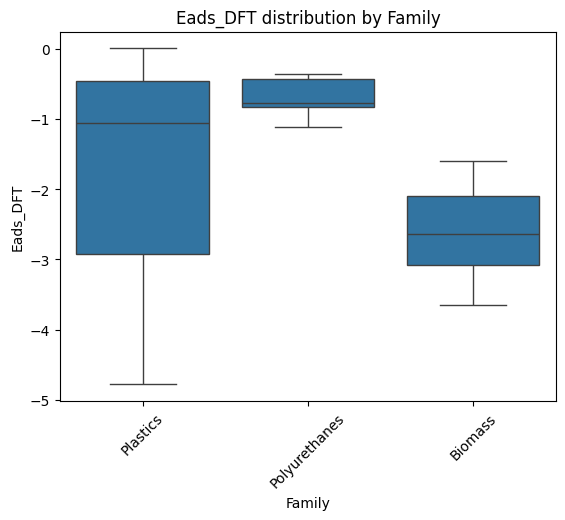

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of adsorption energy by family
sns.boxplot(data=df, x='Family', y='Eads_DFT')
plt.xticks(rotation=45)
plt.title('Eads_DFT distribution by Family')
plt.show()


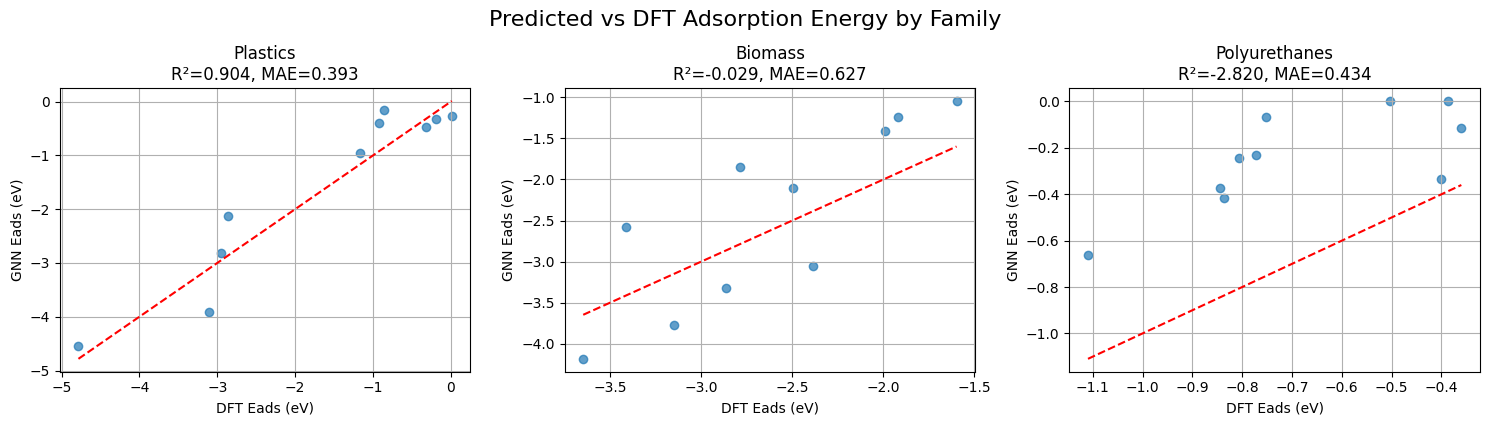

Plastics: R² = 0.904, MAE = 0.393, RMSE = 0.471
Biomass: R² = -0.029, MAE = 0.627, RMSE = 0.646
Polyurethanes: R² = -2.820, MAE = 0.434, RMSE = 0.464


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


path ="/content/drive/MyDrive/project ch5650/GAME-Net_predictions (1).csv"

df = pd.read_csv(path)

groups = ['Plastics', 'Biomass', 'Polyurethanes']
metrics = {}

plt.figure(figsize=(15, 4))

for i, group in enumerate(groups):
    group_df = df[df['Family'] == group]
    y_true = group_df['Eads_DFT'].values
    y_pred = group_df['Eads_GNN'].values

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    metrics[group] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}

    # Plotting
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.title(f'{group}\nR²={r2:.3f}, MAE={mae:.3f}')
    plt.xlabel('DFT Eads (eV)')
    plt.ylabel('GNN Eads (eV)')
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Predicted vs DFT Adsorption Energy by Family", y=1.05, fontsize=16)
plt.show()

for group, m in metrics.items():
    print(f"{group}: R² = {m['R2']:.3f}, MAE = {m['MAE']:.3f}, RMSE = {m['RMSE']:.3f}")


Our Graph Neural Network (GNN) model was tested on the BM dataset, which contains large and chemically diverse organic molecules categorized into families such as Plastics, Biomass, and Polyurethanes, each representing complex molecular structures relevant to sustainability and materials science. The model's performance was evaluated by comparing its predicted adsorption energies (Eads) against reference values computed using Density Functional Theory (DFT). Results showed strong predictive performance for Plastics, with an R² of 0.904, MAE of 0.393 eV, and RMSE of 0.471 eV, indicating a high correlation between predicted and actual values. However, the model struggled with the Biomass and Polyurethanes families, where it yielded negative R² values (−0.029 and −2.820, respectively), reflecting poor predictive accuracy. Despite lower MAE and RMSE for Polyurethanes (0.434 and 0.464 eV) compared to Biomass (0.627 and 0.646 eV), the negative R² suggests the model failed to capture meaningful trends in those datasets.
